<a href="https://colab.research.google.com/github/sebamiles/IAPred/blob/main/IApred-Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Intrinsic Antigenicity: 1.12 (High)


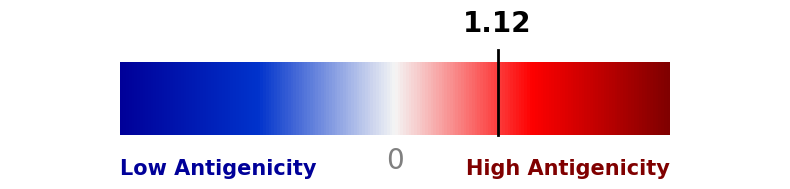

In [ ]:
!pip install Biopython # joblib scikit-learn matplotlib

import sys
import os
import numpy as np
from Bio import SeqIO
import csv
from google.colab import files
from IPython.display import display, HTML
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from collections import Counter
import re
from joblib import load
from sklearn.feature_selection import VarianceThreshold
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def create_score_visualization(score):

    # Create the plot
    colors = ['#000099', '#0033cc', '#F5F5F5', '#ff0000', '#800000']
    n_bins = 200
    cmap = LinearSegmentedColormap.from_list('custom', colors, N=n_bins)
    fig, ax = plt.subplots(figsize=(8, 2))
    fig.patch.set_facecolor('white')
    gradient = np.linspace(-3, 3, 400).reshape(1, -1)
    ax.imshow(gradient, cmap=cmap, aspect='auto', extent=[-3, 3, 0, 0.6])

    # Add a marker for the score
    ax.plot([score, score], [0, 0.7], color='black', linewidth=2)
    ax.text(score, 0.8, f'{score:.2f}', ha='center', va='bottom', fontsize=20,
            fontweight='bold', fontfamily='sans-serif', color='black')

    # Add text for low and high antigenicity
    ax.text(-3, -0.2, 'Low Antigenicity', ha='left', va='top', fontsize=15,
            fontweight='bold', fontfamily='sans-serif', color='#000099')
    ax.text(3, -0.2, 'High Antigenicity', ha='right', va='top', fontsize=15,
            fontweight='bold', fontfamily='sans-serif', color='#800000')

    # Add a '0' below the center of the bar
    ax.text(0, -0.1, '0', ha='center', va='top', fontsize=20,
            fontfamily='sans-serif', color='gray')

    # Set the axis limits and remove ticks
    ax.set_xlim(-4.2, 4.2)
    ax.set_ylim(-0.3, 1)
    ax.set_xticks([])
    ax.set_yticks([])

    # Remove axis spines
    for spine in ax.spines.values():
        spine.set_visible(False)

    plt.tight_layout()
    return fig

def process_fasta_file(fasta_content, output_csv, model, scaler, variance_selector,
                      feature_selector, feature_mask, all_feature_names, long_output=True, color_scale=False):

    results = []
    low_antigenicity_count = 0
    moderate_antigenicity_count = 0
    high_antigenicity_count = 0

    # Parse sequences from the content
    sequences = []
    current_header = ''
    current_sequence = ''

    for line in fasta_content.split('\n'):
        line = line.strip()
        line = ''.join(c for c in line if c.isprintable() and ord(c) < 128)
        if line.startswith('>'):
            if current_header and current_sequence:
                sequences.append((current_header, current_sequence))
            current_header = line[1:]
            current_sequence = ''
        elif line:
            current_sequence += line

    # Add the last sequence
    if current_header and current_sequence:
        sequences.append((current_header, current_sequence))

    total_sequences = len(sequences)
    print(f"Found {total_sequences} sequences")

    # Create/open CSV file for writing results
    with open(output_csv, 'w', newline='', encoding='utf-8') as csv_file:
        csv_writer = csv.writer(csv_file)
        csv_writer.writerow(['Header', 'Sequence_Length', 'Intrinsic_Antigenicity_Score', 'Antigenicity_Category'])

        for i, (header, sequence) in enumerate(sequences, 1):
            header = header[:20]
            score, category = evaluate_single_sequence(sequence, model, scaler,
                                                    variance_selector, feature_selector,
                                                    feature_mask, all_feature_names)

            if score is None:
                print(f"\nWarning: {category} for {header}")
                csv_writer.writerow([header, len(sequence) if sequence else 0, category, "N/A"])
                continue

            if long_output:
                print(f"\nProcessing sequence {i}/{total_sequences}: {header}")
                print(f"Intrinsic Antigenicity: {score:.2f} ({category})")
                if color_scale:
                    fig = create_score_visualization(score)
                    plt.show()
                    plt.close(fig)
                else:
                    print(create_ascii_visualization(score))
            else:
                print(f"\rProcessing: {i}/{total_sequences} - {header}: {score:.2f} ({category})", end='')

            csv_writer.writerow([header, len(sequence), f"{score:.2f}", category])
            results.append((header, score, category))

            if category == "Low":
                low_antigenicity_count += 1
            elif category == "High":
                high_antigenicity_count += 1
            else:
                moderate_antigenicity_count += 1

    if not long_output:
        print()

    print(f"\nAntigenicity Summary:")
    print(f"Low Antigenicity (score < -0.3): {low_antigenicity_count} sequences")
    print(f"Moderate Antigenicity (-0.3 to 0.3): {moderate_antigenicity_count} sequences")
    print(f"High Antigenicity (score > 0.3): {high_antigenicity_count} sequences")

    return results

def main(sequence="", long_output=True, save_results=True, color_scale=False):

    # Load models
    models_folder = "models"
    if not os.path.isdir(models_folder):
        print(f"Error: The '{models_folder}' folder does not exist in the current directory.")
        return

    try:
        svm_model = load(os.path.join(models_folder, 'AntigenPred_SVM.joblib'))
        scaler = load(os.path.join(models_folder, 'AntigenPred_scaler.joblib'))
        variance_selector = load(os.path.join(models_folder, 'AntigenPred_variance_selector.joblib'))
        feature_selector = load(os.path.join(models_folder, 'AntigenPred_feature_selector.joblib'))
        feature_mask = load(os.path.join(models_folder, 'AntigenPred_feature_mask.joblib'))
        all_feature_names = load(os.path.join(models_folder, 'AntigenPred_all_feature_names.joblib'))
    except Exception as e:
        print(f"Error loading model files: {str(e)}")
        return

    if sequence.strip():
        score, category = evaluate_single_sequence(sequence, svm_model, scaler,
                                                variance_selector, feature_selector,
                                                feature_mask, all_feature_names)

        if score is not None:
            if long_output:
                print(f"\nIntrinsic Antigenicity: {score:.2f} ({category})")
                if color_scale:
                    fig = create_score_visualization(score)
                    plt.show()
                    plt.close(fig)
                else:
                    print(create_ascii_visualization(score))
            else:
                print(f"Score: {score:.2f} ({category})")
        else:
            print(f"\nError: {category}")

    else:
        print("Please upload your FASTA file:")
        uploaded = files.upload()

        if not uploaded:
            print("No file was uploaded.")
            return

        filename = list(uploaded.keys())[0]
        content = uploaded[filename].decode('utf-8')
        output_csv = os.path.splitext(filename)[0] + '_results.csv'

        results = process_fasta_file(content, output_csv, svm_model, scaler,
                                   variance_selector, feature_selector,
                                   feature_mask, all_feature_names,
                                   long_output, color_scale)

        if save_results:
            print(f"\nResults have been saved to {output_csv}")
            files.download(output_csv)
        else:
            if os.path.exists(output_csv):
                os.remove(output_csv)

#  Usage:
if __name__ == "__main__":

    sequence = "DCKPDFSYAIAKNDKIGPLGAEGLTTTWYEYSDGMRLKDTMVEVWCKDGEFMFLKKCARETRYLAILHTRALPTSVVFKKIFDGQKQADTVEMDDNFEFGLCPCDAKPVVRGKFNTTLLNGPAFQMVCPIGWTGTVSCTLANEDTLDTTVVRTYRRTKPFPYRQGCITQKVVGEDLYDCILGGNWTCIAGDQLKYTGGPIESCKWCGYKFQKSEGLPHYPIGKCRLKNETGYRLVDDTSCNRDGVAIVPTGTVKCKIGDTVVQVIAMDTKLGPMPCKPYEIISSEGPVEKTACTFNYTKTLKNKYFEPRDSYFQQYMLKGEYQYWFDL" # @param {"type":"string"}
    long_output = True # @param {"type":"boolean"}
    save_results = False # @param {"type":"boolean"}
    color_scale = True  # @param {"type":"boolean"}

    main(sequence=sequence, long_output=long_output, save_results=save_results, color_scale=color_scale)